In [21]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors
from helpers import load_from_path, save_pdf

In [22]:
from mobo.surrogate_model import BoTorchSurrogateModelReapeatMean, BoTorchSurrogateModel
import numpy as np
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import yaml

In [23]:
path = Path("../result/exp4d/unroll_new/marsdet/0/")
# path = Path("../result/exp/unroll_new/raqnehvi/0/")
path = Path("../result/peaksS5R3/default/mars/0/")
# path = Path("../result/peaks/default/qnehvi/0/")
path = Path("../good results/peaks/risk-averse1/qnehvi/0/")

res_dict = load_from_path(path)
eval_samples = res_dict["eval_samples"]
n_obj = res_dict["n_obj"]
sobol = res_dict["sobol"]

# train_X = eval_samples[["x1", "x2", "x3", "x4"]].values
# use pandas filter to select columns
train_X = eval_samples.filter(regex="^x[0-9]").values
train_Y = eval_samples.filter(regex="^f[0-9]").values
train_Yvar = eval_samples.filter(regex="^rho_f[0-9]").values

import torch

# np to torch
train_X = torch.tensor(train_X, dtype=torch.float64)
train_Y = -torch.tensor(train_Y, dtype=torch.float64)
train_Yvar = torch.tensor(train_Yvar, dtype=torch.float64)

# min max bounds from train_X
bounds = torch.stack([train_X.min(0)[0], train_X.max(0)[0]])


In [24]:

# normalize
from botorch.utils.transforms import normalize, unnormalize

# outcome transform
from botorch.models.transforms.outcome import Standardize, Log

train_X = normalize(train_X, bounds)

from botorch.models import SingleTaskGP


class MyModel(SingleTaskGP):
    def __init__(self, train_X, train_Y, train_Yvar=None, *args, **kwargs):
        super().__init__(
            train_X=train_X,
            train_Y=train_Y,
            train_Yvar=train_Yvar,
            outcome_transform=Standardize(m=train_Y.shape[-1],
                                          batch_shape=torch.Size([len(train_Y)])),
            *args,
            **kwargs
        )


from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.cross_validation import batch_cross_validation, gen_loo_cv_folds

cv_folds = gen_loo_cv_folds(train_X, train_Y, train_Yvar)
cv_results = batch_cross_validation(
    MyModel,
    ExactMarginalLogLikelihood,
    cv_folds,
)
cv_results


CVResults(model=MyModel(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
  (outcome_transform): Standardize()
), posterior=<botorch.posteriors.gpytorch.GPyTorchPosterior object at 0x000001C565849700>, observed_Y=tensor([[[-0.0671,  0.1677]],

        [[-0.3974,  0.0070]],

        [[-0.1485, -0.0873]],

        [[-0.0507,  0.1075]],

        [[-0.1202, -0.1805]],

        [[-0.4663,  0.1047]],

        [[-0.1031, -0.0310]],

        [[-0.0609,  0.1234]],

        [[-0.0144, -0.3219]],

        [[-0.0601,  0.1108]],

        [[-0.1824, -0.3975]],

        [[-0.1509, -0.4064]],

        [[-0.0528,  0.1022]],

        [[-0.3628, -0.4026]],

        [[-0.0123,  0.2053]],

     

In [25]:
# class MyNoiseModel(SingleTaskGP):
#     def __init__(self, train_X, train_Y, train_Yvar=None, *args, **kwargs):
#         super().__init__(
#             train_X=train_X,
#             train_Y=train_Y,
#             *args,
#             **kwargs
#         )


# from gpytorch.mlls import ExactMarginalLogLikelihood
# from botorch.cross_validation import batch_cross_validation, gen_loo_cv_folds

# cv_folds_noise = gen_loo_cv_folds(train_X, train_Yvar)
# cv_results_noise = batch_cross_validation(
#     MyNoiseModel,
#     ExactMarginalLogLikelihood,
#     cv_folds,
# )
# cv_results_noise

Mean Absolute Percentage Error for each objective: [251.4894624  200.83288888]


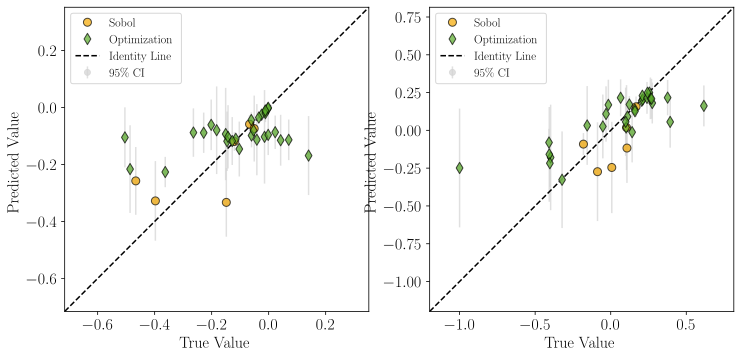

In [36]:
train_Y = cv_results.observed_Y.squeeze()
train_Yvar = cv_results.observed_Yvar.squeeze()
pred_posterior = cv_results.posterior
pred_Y = pred_posterior.mean.squeeze().detach()
pred_Yvar = pred_posterior.variance.squeeze().detach()
# pred_Yvar = cv_results.observed_Yvar.squeeze()
# noise_posterior = cv_results_noise.posterior
# pred_Yvar = noise_posterior.mean.squeeze()


%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    # font size
    "font.size": 16,
})

pred_Ystd = torch.sqrt(pred_Yvar)



color_list = defaultColors

# Prepare the plot
fig, ax = plt.subplots(1, n_obj, 
                       figsize=(3*n_obj + 6, 6),
                       dpi=600)

for i in range(n_obj):
    
    # Error bars for confidence intervals
    # Scatter plot for predictions vs. true values
    ax[i].errorbar(train_Y[:, i], pred_Y[:, i], yerr=pred_Ystd[:, i], fmt='o', color="lightgray", alpha=0.7, label="95\% CI")
    # ax[i].plot(train_Y[:, i], pred_Y[:, i], alpha=0.9, color=colors, markeredgecolor="black", linestyle="None", marker="o", markersize=8,
    #               zorder=5,)
    
    # Sobol experiments
    ax[i].plot(train_Y[sobol, i], pred_Y[sobol, i], alpha=0.7, color=color_list[0], markeredgecolor="black", linestyle="None", marker="o", markersize=8,
                    zorder=5, label="Sobol")
    # Optimization experiments
    ax[i].plot(train_Y[~sobol, i], pred_Y[~sobol, i], alpha=0.7, color=color_list[1], markeredgecolor="black", linestyle="None", marker="d", markersize=8,
                    zorder=5, label="Optimization")
    
    
    # Identity line
    max_val = max(max(train_Y[:, i]), max(pred_Y[:, i])) + train_Yvar[:, i].mean() * 2
    min_val = min(min(train_Y[:, i]), min(pred_Y[:, i])) - train_Yvar[:, i].mean() * 2
    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', label="Identity Line")
    
    # Set limits for better comparison
    # ax[i].set_xlim([ 0, max_val])
    # ax[i].set_ylim([ 0, max_val])
    ax[i].set_xlim([ min_val, max_val])
    ax[i].set_ylim([ min_val, max_val])
    
    # Enhance labeling
    ax[i].set_xlabel("True Value")
    ax[i].set_ylabel("Predicted Value")
    # ax[i].set_title(f"Objective {i+1} Parity Plot")
    ax[i].set_aspect('equal', adjustable='box')

    #empty plot for legend
    # marker with outline in black
    
    ax[i].legend(fontsize=12, loc="upper left")
    

save_pdf(fig, path, "parity_plot")

# Calculate and print MAPE for each objective
mape = torch.mean(torch.abs((train_Y - pred_Y) / train_Y), axis=0) * 100

 
print("Mean Absolute Percentage Error for each objective:", mape.numpy())
